<a href="https://colab.research.google.com/github/FatimaZahraBoujrad/phishing_classification/blob/main/phishing_url_dns_ssl_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import et dépendances**

In [ ]:
# Installation de python-Levenshtein pour le calcul de distance entre strings
!pip install python-Levenshtein

import pandas as pd
import numpy as np
import re
import math
from urllib.parse import urlparse
from datetime import datetime, timezone
from collections import Counter
from Levenshtein import distance as levenshtein_distance

# Supprimer ipaddress si déjà importé pour éviter les conflits
import sys
if 'ipaddress' in sys.modules:
    del sys.modules['ipaddress']

**Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ⚙️ Configuration et Constantes

Nous définissons :
- **Mots sensibles** : mots souvent utilisés dans les tentatives de phishing (login, verify, bank...)
- **Mots de marques** : noms de marques célèbres souvent usurpées (paypal, google, amazon...)
- **Émetteurs SSL courants** : autorités de certification légitimes
- **Chemins vers les datasets** : localisation de vos fichiers CSV

In [ ]:
# Date actuelle pour le calcul de l'âge des certificats SSL
now = datetime.now(timezone.utc)

# Mots sensibles fréquemment utilisés dans les URLs de phishing
SENSITIVE_WORDS = [
    "login", "verify", "secure", "account", "update",
    "bank", "confirm", "password", "signin"
]

# Noms de marques couramment usurpées dans le phishing
BRAND_WORDS = [
    "paypal", "google", "microsoft", "apple",
    "amazon", "facebook", "instagram"
]

# Émetteurs de certificats SSL légitimes et courants
COMMON_ISSUERS = [
    "let's encrypt",
    "google trust",
    "digicert",
    "globalsign",
    "sectigo",
    "amazon",
    "comodoca",
]


# Chemins vers les datasets (à adapter selon votre organisation)
PHISHING_PATH = "/content/drive/MyDrive/Dataset/phishing30k.csv"
BENIGN_PATH = "/content/drive/MyDrive/Dataset/benign30k.csv"

# 🛠️ Fonctions Utilitaires

Ces fonctions servent à :
1. **shannon_entropy** : Calculer l'entropie d'une chaîne (mesure du désordre/randomness)
2. **is_ip_address** : Détecter si un domaine est une adresse IP (technique de phishing courante)

In [ ]:
def shannon_entropy(s):
    """
    Calcule l'entropie de Shannon d'une chaîne de caractères.
    Une entropie élevée indique un contenu plus aléatoire/imprévisible.

    Args:
        s (str): Chaîne de caractères à analyser

    Returns:
        float: Valeur d'entropie (0 = pas aléatoire, >4 = très aléatoire)
    """
    if not s or len(s) == 0:
        return 0
    probs = [s.count(c) / len(s) for c in set(s)]
    return -sum(p * math.log2(p) for p in probs)


def is_ip_address(domain):
    """
    Vérifie si le domaine est une adresse IP (IPv4 ou IPv6).
    Les sites de phishing utilisent parfois des IP au lieu de noms de domaine.

    Args:
        domain (str): Nom de domaine à vérifier

    Returns:
        int: 1 si c'est une IP, 0 sinon
    """
    if not isinstance(domain, str) or domain == "":
        return 0

    # Pattern IPv4: doit matcher exactement (ex: 192.168.1.1)
    ipv4_pattern = r'^(\d{1,3}\.){3}\d{1,3}$'
    if re.match(ipv4_pattern, domain):
        try:
            parts = domain.split('.')
            if all(0 <= int(p) <= 255 for p in parts):
                return 1
        except:
            pass

    # Pattern IPv6 (vérification simplifiée)
    if ':' in domain and re.match(r'^[0-9a-fA-F:]+$', domain):
        return 1

    return 0

# 🔍 Extraction des Features basées sur l'URL

Cette fonction extrait 13 features importantes depuis l'URL :
- Longueurs (URL totale, domaine, chemin, query string)
- Compteurs (sous-domaines, points, tirets, chiffres, caractères spéciaux)
- Indicateurs (présence de @, IP dans le domaine)
- Entropie de l'URL
- Présence de mots sensibles

In [ ]:
def extract_url_features(url):
    """
    Extrait les caractéristiques basées sur la structure de l'URL.

    Args:
        url (str): URL à analyser

    Returns:
        dict: Dictionnaire contenant 13 features extraites
    """
    if not isinstance(url, str):
        url = ""

    parsed = urlparse(url)
    domain = parsed.netloc

    return {
        "url_len": len(url),                                    # Longueur totale de l'URL
        "domain_len": len(domain),                              # Longueur du domaine
        "path_len": len(parsed.path),                           # Longueur du chemin
        "query_len": len(parsed.query),                         # Longueur des paramètres
        "num_subdomains": max(0, domain.count(".") - 1),       # Nombre de sous-domaines
        "num_dots": domain.count("."),                          # Nombre de points
        "num_hyphens": domain.count("-"),                       # Nombre de tirets
        "num_digits": sum(c.isdigit() for c in domain),        # Nombre de chiffres
        "num_special_chars": sum(not c.isalnum() for c in domain),  # Caractères spéciaux
        "has_at_symbol": int("@" in url),                       # Présence de @ (suspect)
        "has_ip_in_domain": is_ip_address(domain),             # Domaine = IP ?
        "url_entropy": shannon_entropy(domain),                 # Entropie du domaine
        "num_sensitive_words": sum(w in url.lower() for w in SENSITIVE_WORDS)  # Mots sensibles
    }

# 🔄 Extraction des Features de Redirection

Les sites de phishing redirigent souvent vers un domaine différent de l'URL initiale.
Cette fonction compare l'URL de départ avec l'URL de destination.

In [ ]:
def extract_redirection_features(url, dest_url):
    """
    Analyse les différences entre l'URL initiale et l'URL de destination.

    Args:
        url (str): URL initiale
        dest_url (str): URL de destination après redirection

    Returns:
        dict: Features de redirection (différence de domaine, distance Levenshtein)
    """
    try:
        if not isinstance(url, str) or not isinstance(dest_url, str):
            return {"dest_diff_domain": 0, "url_dest_levenshtein": 0}

        d1 = urlparse(url).netloc
        d2 = urlparse(dest_url).netloc

        return {
            "dest_diff_domain": int(d1 != d2),                          # Domaines différents ?
            "url_dest_levenshtein": levenshtein_distance(d1, d2) if d1 and d2 else 0  # Distance
        }
    except Exception:
        return {"dest_diff_domain": 0, "url_dest_levenshtein": 0}

# 🔐 Extraction des Features SSL/TLS

Les certificats SSL fournissent des informations importantes :
- Âge du certificat (les certificats très récents peuvent être suspects)
- Durée de validité
- Émetteur du certificat (Let's Encrypt, DigiCert, etc.)

In [ ]:
def extract_ssl_features(row, current_time):
    features = {
        "ssl_cert_age_days": 0,
        "ssl_cert_lifetime_days": 0,
        "ssl_issuer_is_common": 0
    }

    # ---- DATES ----
    start = pd.to_datetime(row.get("ssl_valid_from"), utc=True, errors="coerce")
    end   = pd.to_datetime(row.get("ssl_valid_until"), utc=True, errors="coerce")

    if start is not pd.NaT and end is not pd.NaT:
        features["ssl_cert_age_days"] = max((current_time - start).days, 0)
        features["ssl_cert_lifetime_days"] = max((end - start).days, 0)

    # ---- ISSUER ----
    issuer = str(row.get("ssl_issuer","")).lower()
    features["ssl_issuer_is_common"] = int(any(ci in issuer for ci in COMMON_ISSUERS))

    return features




# 🌐 Extraction des Features DNS

Les enregistrements DNS révèlent la configuration réseau du domaine :
- Enregistrement A (IPv4)
- Enregistrement AAAA (IPv6)
- Enregistrement MX (serveur mail)

Une configuration DNS incomplète peut être suspecte.

In [ ]:
def extract_dns_features(row):
    """
    Analyse les enregistrements DNS du domaine.

    Args:
        row (pd.Series): Ligne contenant les statuts DNS

    Returns:
        dict: Features DNS (présence d'enregistrements A/AAAA/MX, configuration complète)
    """
    a_status = str(row.get("dns_a_status", "")).upper()
    aaaa_status = str(row.get("dns_aaaa_status", "")).upper()
    mx_status = str(row.get("dns_mx_status", "")).upper()

    dns_has_a = int(a_status == "NOERROR")
    dns_has_aaaa = int(aaaa_status == "NOERROR")
    dns_has_mx = int(mx_status == "NOERROR")

    return {
        "dns_has_a": dns_has_a,                                   # A record présent ?
        "dns_has_aaaa": dns_has_aaaa,                            # AAAA record présent ?
        "dns_has_mx": dns_has_mx,                                # MX record présent ?
        "dns_complete": int(dns_has_a and dns_has_mx),          # Config DNS complète ?
        "dns_is_suspicious": int(not dns_has_a and not dns_has_mx)  # Aucun record ?
    }

# 🏢 Extraction des Features ASN (Autonomous System Number)

L'ASN identifie l'opérateur réseau qui héberge le site.
- Certains ASN sont plus fréquemment utilisés (AWS, Cloudflare, Google Cloud)
- L'absence d'ASN ou de code pays peut être suspect

In [ ]:
def extract_asn_features(row, asn_freq):
    """
    Extrait les caractéristiques liées à l'hébergeur (ASN).

    Args:
        row (pd.Series): Ligne contenant les infos ASN
        asn_freq (Counter): Fréquence des ASN dans le dataset

    Returns:
        dict: Features ASN (présence, fréquence, code pays manquant)
    """
    asn_code = row.get("maxmind_1_asn_code")
    return {
        "asn_present": int(pd.notna(asn_code)),                           # ASN présent ?
        "asn_freq_score": asn_freq.get(asn_code, 0) if pd.notna(asn_code) else 0,  # Fréquence
        "cc_is_missing": int(pd.isna(row.get("maxmind_1_cc_code")))      # Code pays manquant ?
    }

# 📄 Extraction des Features du Titre de la Page

Le titre de la page HTML peut révéler des tentatives de phishing :
- Présence de noms de marques célèbres
- Mots sensibles (login, verify, secure...)
- Décalage entre le titre et le domaine (ex: titre "PayPal" mais domaine "paypai.com")

In [ ]:
def extract_title_features(title, url):
    """
    Analyse le titre de la page HTML.

    Args:
        title (str): Titre de la page
        url (str): URL correspondante

    Returns:
        dict: Features du titre (longueur, mots de marques, mismatch avec l'URL)
    """
    if not isinstance(title, str):
        title = ""
    if not isinstance(url, str):
        url = ""

    domain = urlparse(url).netloc.lower()

    return {
        "title_len": len(title),                                          # Longueur du titre
        "title_has_brand_words": int(any(b in title.lower() for b in BRAND_WORDS)),  # Marque ?
        "title_has_sensitive_words": int(any(w in title.lower() for w in SENSITIVE_WORDS)),  # Sensible ?
        "title_is_upper": int(title.isupper()) if len(title) > 0 else 0,  # Tout en majuscules ?
        "title_url_mismatch": int(                                        # Mismatch titre/domaine ?
            any(b in title.lower() for b in BRAND_WORDS) and
            not any(b in domain for b in BRAND_WORDS)
        )
    }

# 🏗️ Construction de la Matrice de Features Complète

Cette fonction orchestre l'extraction de toutes les features pour l'ensemble du dataset :
1. Calcule la fréquence des ASN
2. Parcourt chaque ligne du dataset
3. Applique toutes les fonctions d'extraction
4. Gère les erreurs gracieusement
5. Retourne un DataFrame avec 33 features

In [ ]:
def build_features(df):
    """
    Construit la matrice complète de features pour tout le dataset.

    Args:
        df (pd.DataFrame): DataFrame contenant les données brutes

    Returns:
        pd.DataFrame: Matrice de features (59182 lignes × 33 colonnes)
    """
    print(f"🔧 Construction des features pour {len(df)} URLs...")
    feature_rows = []

    # Capture du timestamp actuel pour les calculs SSL
    current_time = datetime.now(timezone.utc)

    # Calculer la fréquence des ASN dans le dataset
    asn_freq = Counter(df["maxmind_1_asn_code"].dropna())

    for idx, row in df.iterrows():
        try:
            features = {}

            # Extraction de toutes les catégories de features
            features.update(extract_url_features(row.get("url", "")))
            features.update(extract_redirection_features(row.get("url", ""), row.get("destination_url", "")))
            features.update(extract_ssl_features(row, current_time))
            features.update(extract_dns_features(row))
            features.update(extract_asn_features(row, asn_freq))
            features.update(extract_title_features(row.get("title", ""), row.get("url", "")))

            # Features binaires directes
            features["is_https"] = int(row.get("is_https", False))
            features["ssl_is_valid_cert"] = int(row.get("ssl_is_valid_cert", False))

            feature_rows.append(features)

            # Affichage de la progression tous les 5000 lignes
            if (idx + 1) % 5000 == 0:
                print(f"  ✓ {idx + 1}/{len(df)} lignes traitées...")

        except Exception as e:
            print(f"  ⚠️ Erreur à la ligne {idx}: {e}")
            # Ajouter une ligne de zéros en cas d'erreur
            if feature_rows:
                feature_rows.append({k: 0 for k in feature_rows[0].keys()})
            else:
                feature_rows.append({}) # Fallback for the very first row error

    print(f"✅ Extraction des features terminée!")
    return pd.DataFrame(feature_rows).fillna(0)

# 📂 Chargement et Préparation des Données

Nous chargeons les deux datasets :
- **phishing30k.csv** : URLs malveillantes
- **benign30k.csv** : URLs légitimes

Puis nous :
1. Ajoutons les labels (1 = phishing, 0 = benign)
2. Équilibrons les classes (même nombre de chaque)
3. Mélangeons aléatoirement pour éviter le biais

In [ ]:
print("="*70)
print("📂 CHARGEMENT DES DONNÉES")
print("="*70)

# Chargement des datasets
phishing = pd.read_csv(PHISHING_PATH)
benign = pd.read_csv(BENIGN_PATH)

# Ajout des labels
phishing["label"] = 1  # 1 = Phishing
benign["label"] = 0    # 0 = Benign (légitime)

# Équilibrage : prendre le même nombre d'exemples pour chaque classe
min_len = min(len(phishing), len(benign))
phishing = phishing.sample(min_len, random_state=42)
benign = benign.sample(min_len, random_state=42)

# Combinaison et mélange aléatoire
df = pd.concat([phishing, benign]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Dataset chargé: {df.shape}")
print(f"   - Phishing: {(df['label'] == 1).sum()}")
print(f"   - Benign: {(df['label'] == 0).sum()}")
print("\n📋 Aperçu des données:")
print(df.head())

📂 CHARGEMENT DES DONNÉES
✅ Dataset chargé: (59182, 53)
   - Phishing: 29591
   - Benign: 29591

📋 Aperçu des données:
                                                 url  is_https dns_a_status  \
0  https://domotz.com/press/domotz-improves-the-c...      True      NOERROR   
1  https://redirect.splashtop.com/my/sos-commerci...      True      NOERROR   
2  https://business-facebocok-manager.bond/robots...      True      NOERROR   
3                          http://condecosftware.com     False      NOERROR   
4                  https://fr1wedu-a12a9.webflow.io/      True      NOERROR   

   dns_a_answer_1 dns_aaaa_status dns_mx_status             ssl_issuer  \
0   18.245.86.119         NOERROR       NOERROR                 Amazon   
1    76.223.35.50         NOERROR       NOERROR                 Amazon   
2  172.67.215.138         NOERROR       NOERROR  Google Trust Services   
3  185.53.179.170         NOERROR       NOERROR          Let's Encrypt   
4   151.101.2.188         NOERROR    

# 🔧 Extraction des Features du Dataset Complet

Nous appliquons maintenant toutes nos fonctions d'extraction sur l'ensemble du dataset.
Cette étape peut prendre quelques minutes (~1-2 minutes pour 60k URLs).

In [ ]:
print("\n" + "="*70)
print("🔧 EXTRACTION DES FEATURES")
print("="*70)

# Extraction des features
X = build_features(df)
y = df["label"].values

print(f"\n✅ Matrice de features: {X.shape}")
print(f"✅ Labels: {y.shape}")
print(f"\n📊 Liste des features ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")


🔧 EXTRACTION DES FEATURES
🔧 Construction des features pour 59182 URLs...
  ✓ 5000/59182 lignes traitées...
  ✓ 10000/59182 lignes traitées...
  ✓ 15000/59182 lignes traitées...
  ✓ 20000/59182 lignes traitées...
  ✓ 25000/59182 lignes traitées...
  ⚠️ Erreur à la ligne 29254: '𝕠𝕞𝕒𝕓𝕢𝕤𝕡.cn' does not appear to be an IPv4 or IPv6 address
  ✓ 30000/59182 lignes traitées...
  ✓ 35000/59182 lignes traitées...
  ✓ 40000/59182 lignes traitées...
  ✓ 45000/59182 lignes traitées...
  ⚠️ Erreur à la ligne 47726: '𝕠𝕞𝕒𝕓𝕢𝕤𝕡.cn' does not appear to be an IPv4 or IPv6 address
  ✓ 50000/59182 lignes traitées...
  ✓ 55000/59182 lignes traitées...
✅ Extraction des features terminée!

✅ Matrice de features: (59182, 33)
✅ Labels: (59182,)

📊 Liste des features (33):
    1. url_len
    2. domain_len
    3. path_len
    4. query_len
    5. num_subdomains
    6. num_dots
    7. num_hyphens
    8. num_digits
    9. num_special_chars
   10. has_at_symbol
   11. has_ip_in_domain
   12. url_entropy
   13. num_sens

# 📊 Analyse Statistique des Features

Visualisons les statistiques descriptives de nos 33 features extraites :
- Moyenne, écart-type
- Min, max
- Quartiles (25%, 50%, 75%)

Cela nous permet de repérer les features les plus variables et potentiellement discriminantes.

In [ ]:
print("\n" + "="*70)
print("📊 STATISTIQUES DESCRIPTIVES")
print("="*70)

X.describe().T


📊 STATISTIQUES DESCRIPTIVES


,count,mean,std,min,25%,50%,75%,max
url_len,59182.0,47.829915,54.859895,0.0,29.000000,37.000000,55.000000,6798.000000
domain_len,59182.0,18.641428,9.120800,0.0,12.000000,17.000000,23.000000,132.000000
path_len,59182.0,16.905410,28.684099,0.0,1.000000,7.000000,22.000000,2073.000000
query_len,59182.0,4.188132,45.828505,0.0,0.000000,0.000000,0.000000,6762.000000
num_subdomains,59182.0,0.651347,0.577597,0.0,0.000000,1.000000,1.000000,6.000000
num_dots,59182.0,1.651313,0.577665,0.0,1.000000,2.000000,2.000000,7.000000
num_hyphens,59182.0,0.332111,0.888709,0.0,0.000000,0.000000,0.000000,16.000000
num_digits,59182.0,0.615474,2.097118,0.0,0.000000,0.000000,0.000000,48.000000
num_special_chars,59182.0,1.989794,1.165318,0.0,1.000000,2.000000,2.000000,19.000000
has_at_symbol,59182.0,0.003346,0.057745,0.0,0.000000,0.000000,0.000000,1.000000


### 📈 Visualisation de la Matrice de Corrélation des Features

Nous allons maintenant visualiser la matrice de corrélation entre toutes les features extraites. Cela nous permettra de détecter d'éventuelles redondances entre les features (corrélation élevée) ou des features qui ne varient pas indépendamment, ce qui peut être utile pour la sélection de features ou la compréhension du modèle.


📊 MATRICE DE CORRÉLATION DES FEATURES


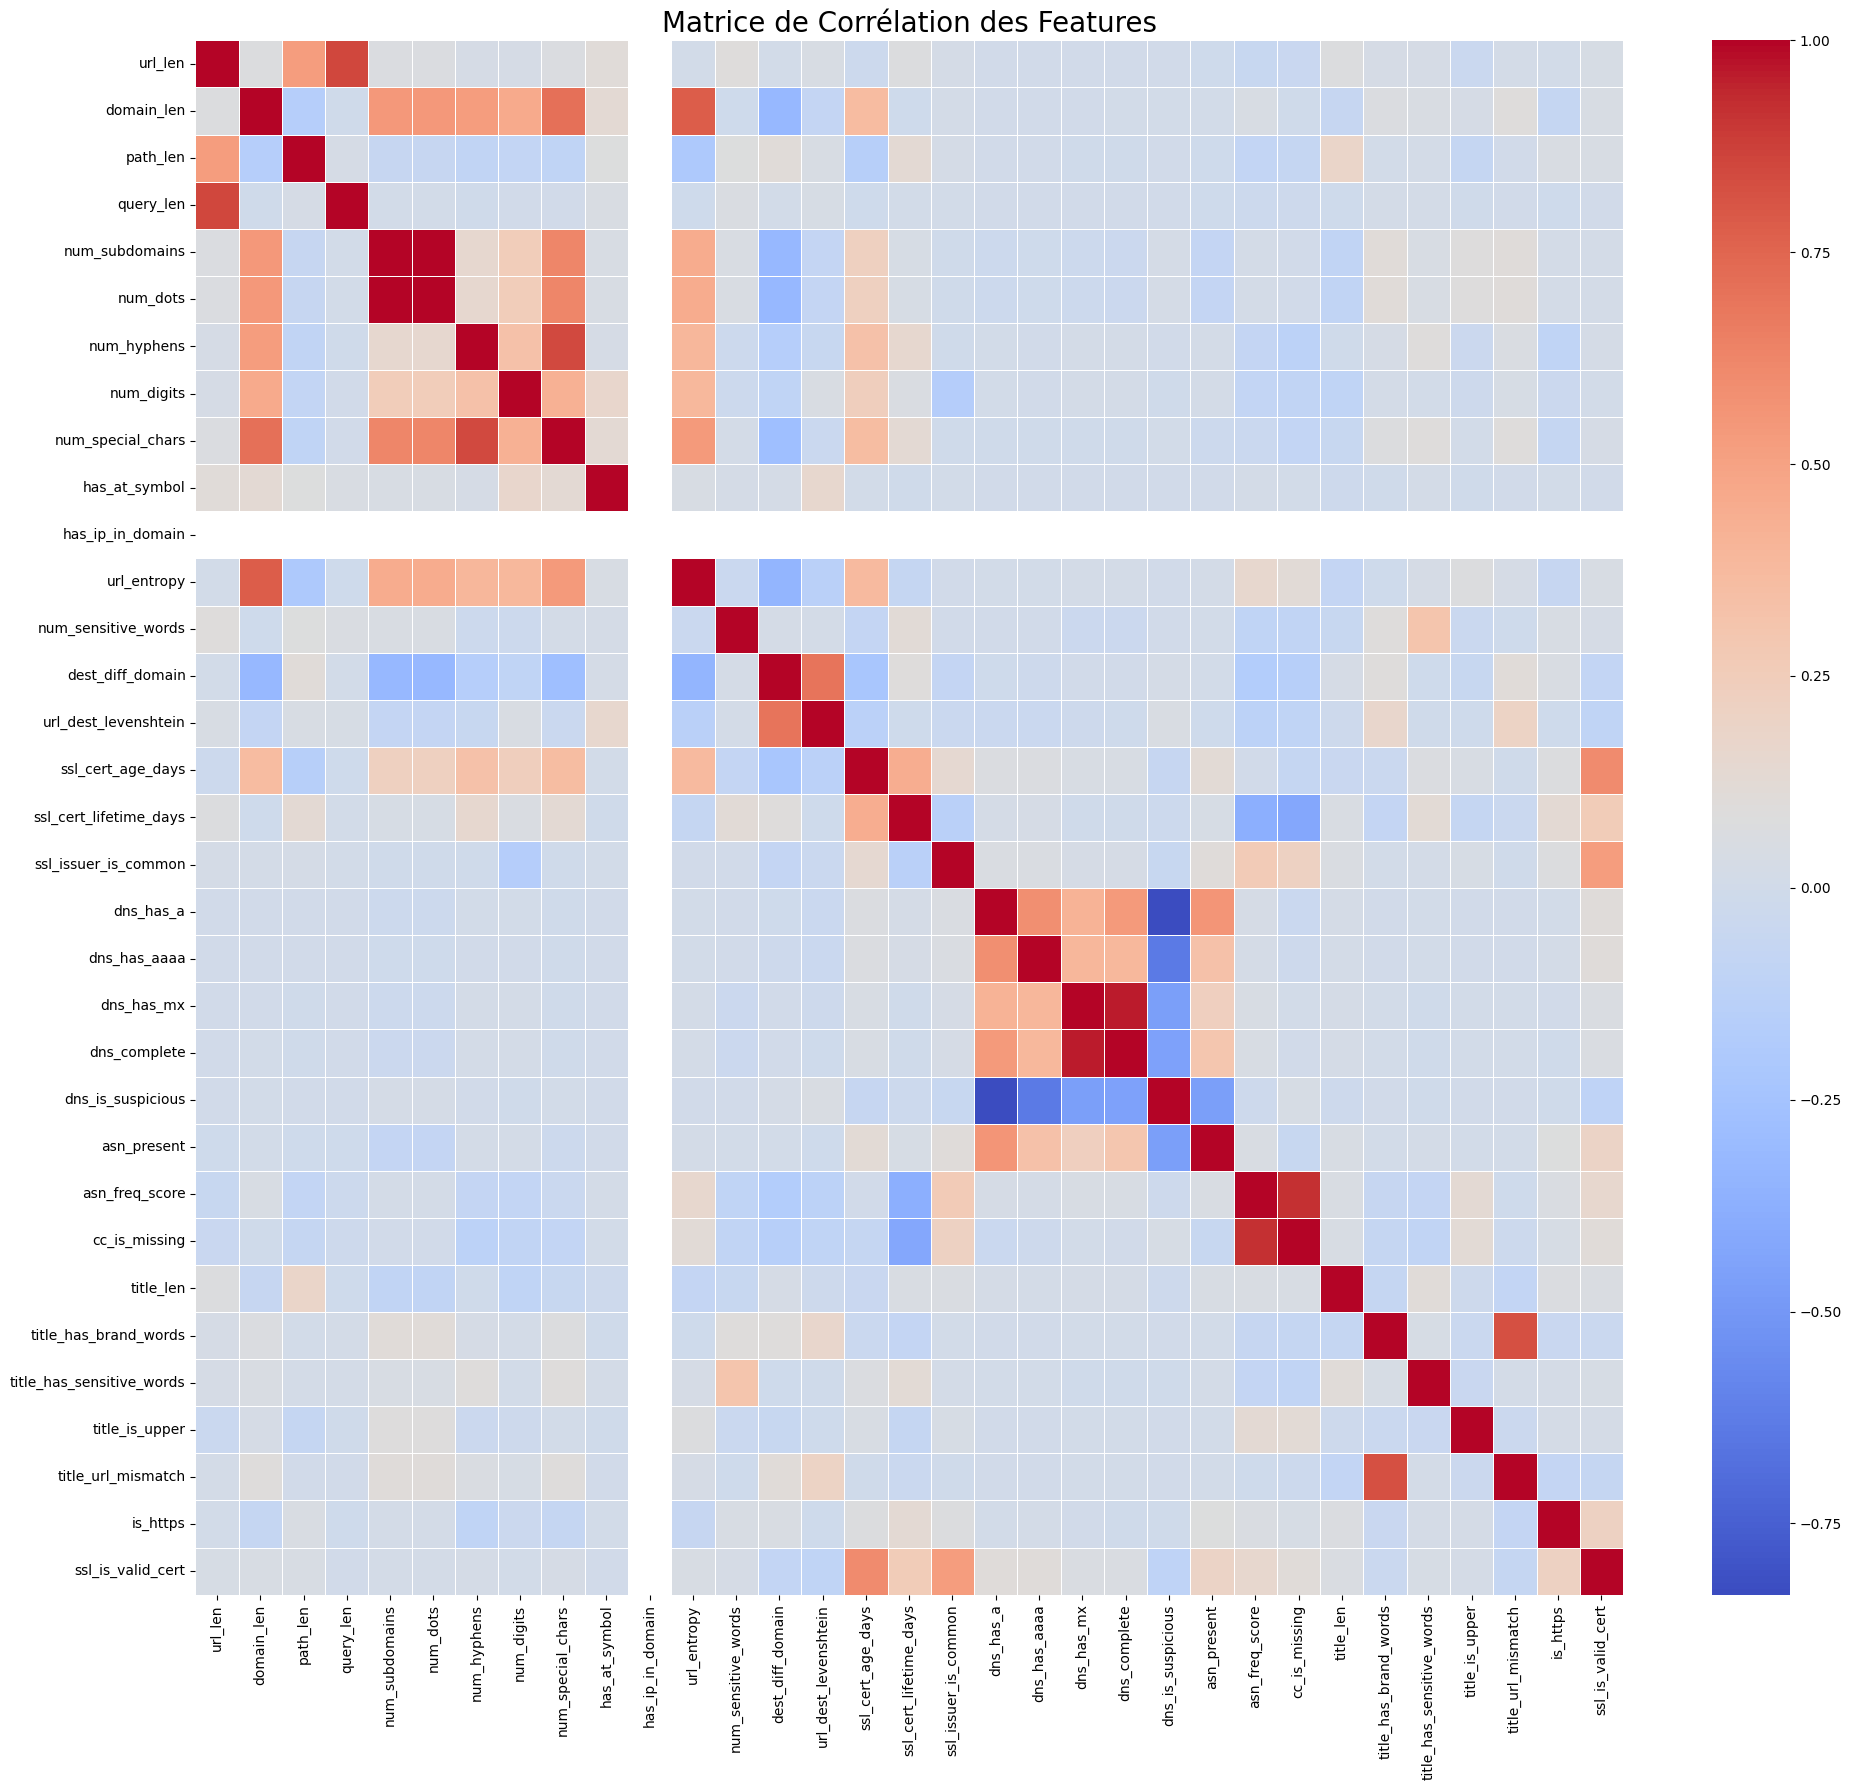

✅ Matrice de corrélation affichée.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("📊 MATRICE DE CORRÉLATION DES FEATURES")
print("="*70)

# Calcul de la matrice de corrélation
correlation_matrix = X.corr()

# Affichage de la heatmap
plt.figure(figsize=(20, 18)) # Ajustez la taille pour une meilleure lisibilité
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation des Features', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Matrice de corrélation affichée.")

### 📈 Visualisation de la Matrice de Corrélation des Features (avec label)

Pour comprendre les relations entre chaque feature et notre variable cible (`label`), nous allons recalculer la matrice de corrélation en incluant les labels. Cela permet d'identifier les features les plus liées à la détection de phishing.


📊 MATRICE DE CORRÉLATION DES FEATURES AVEC LABEL


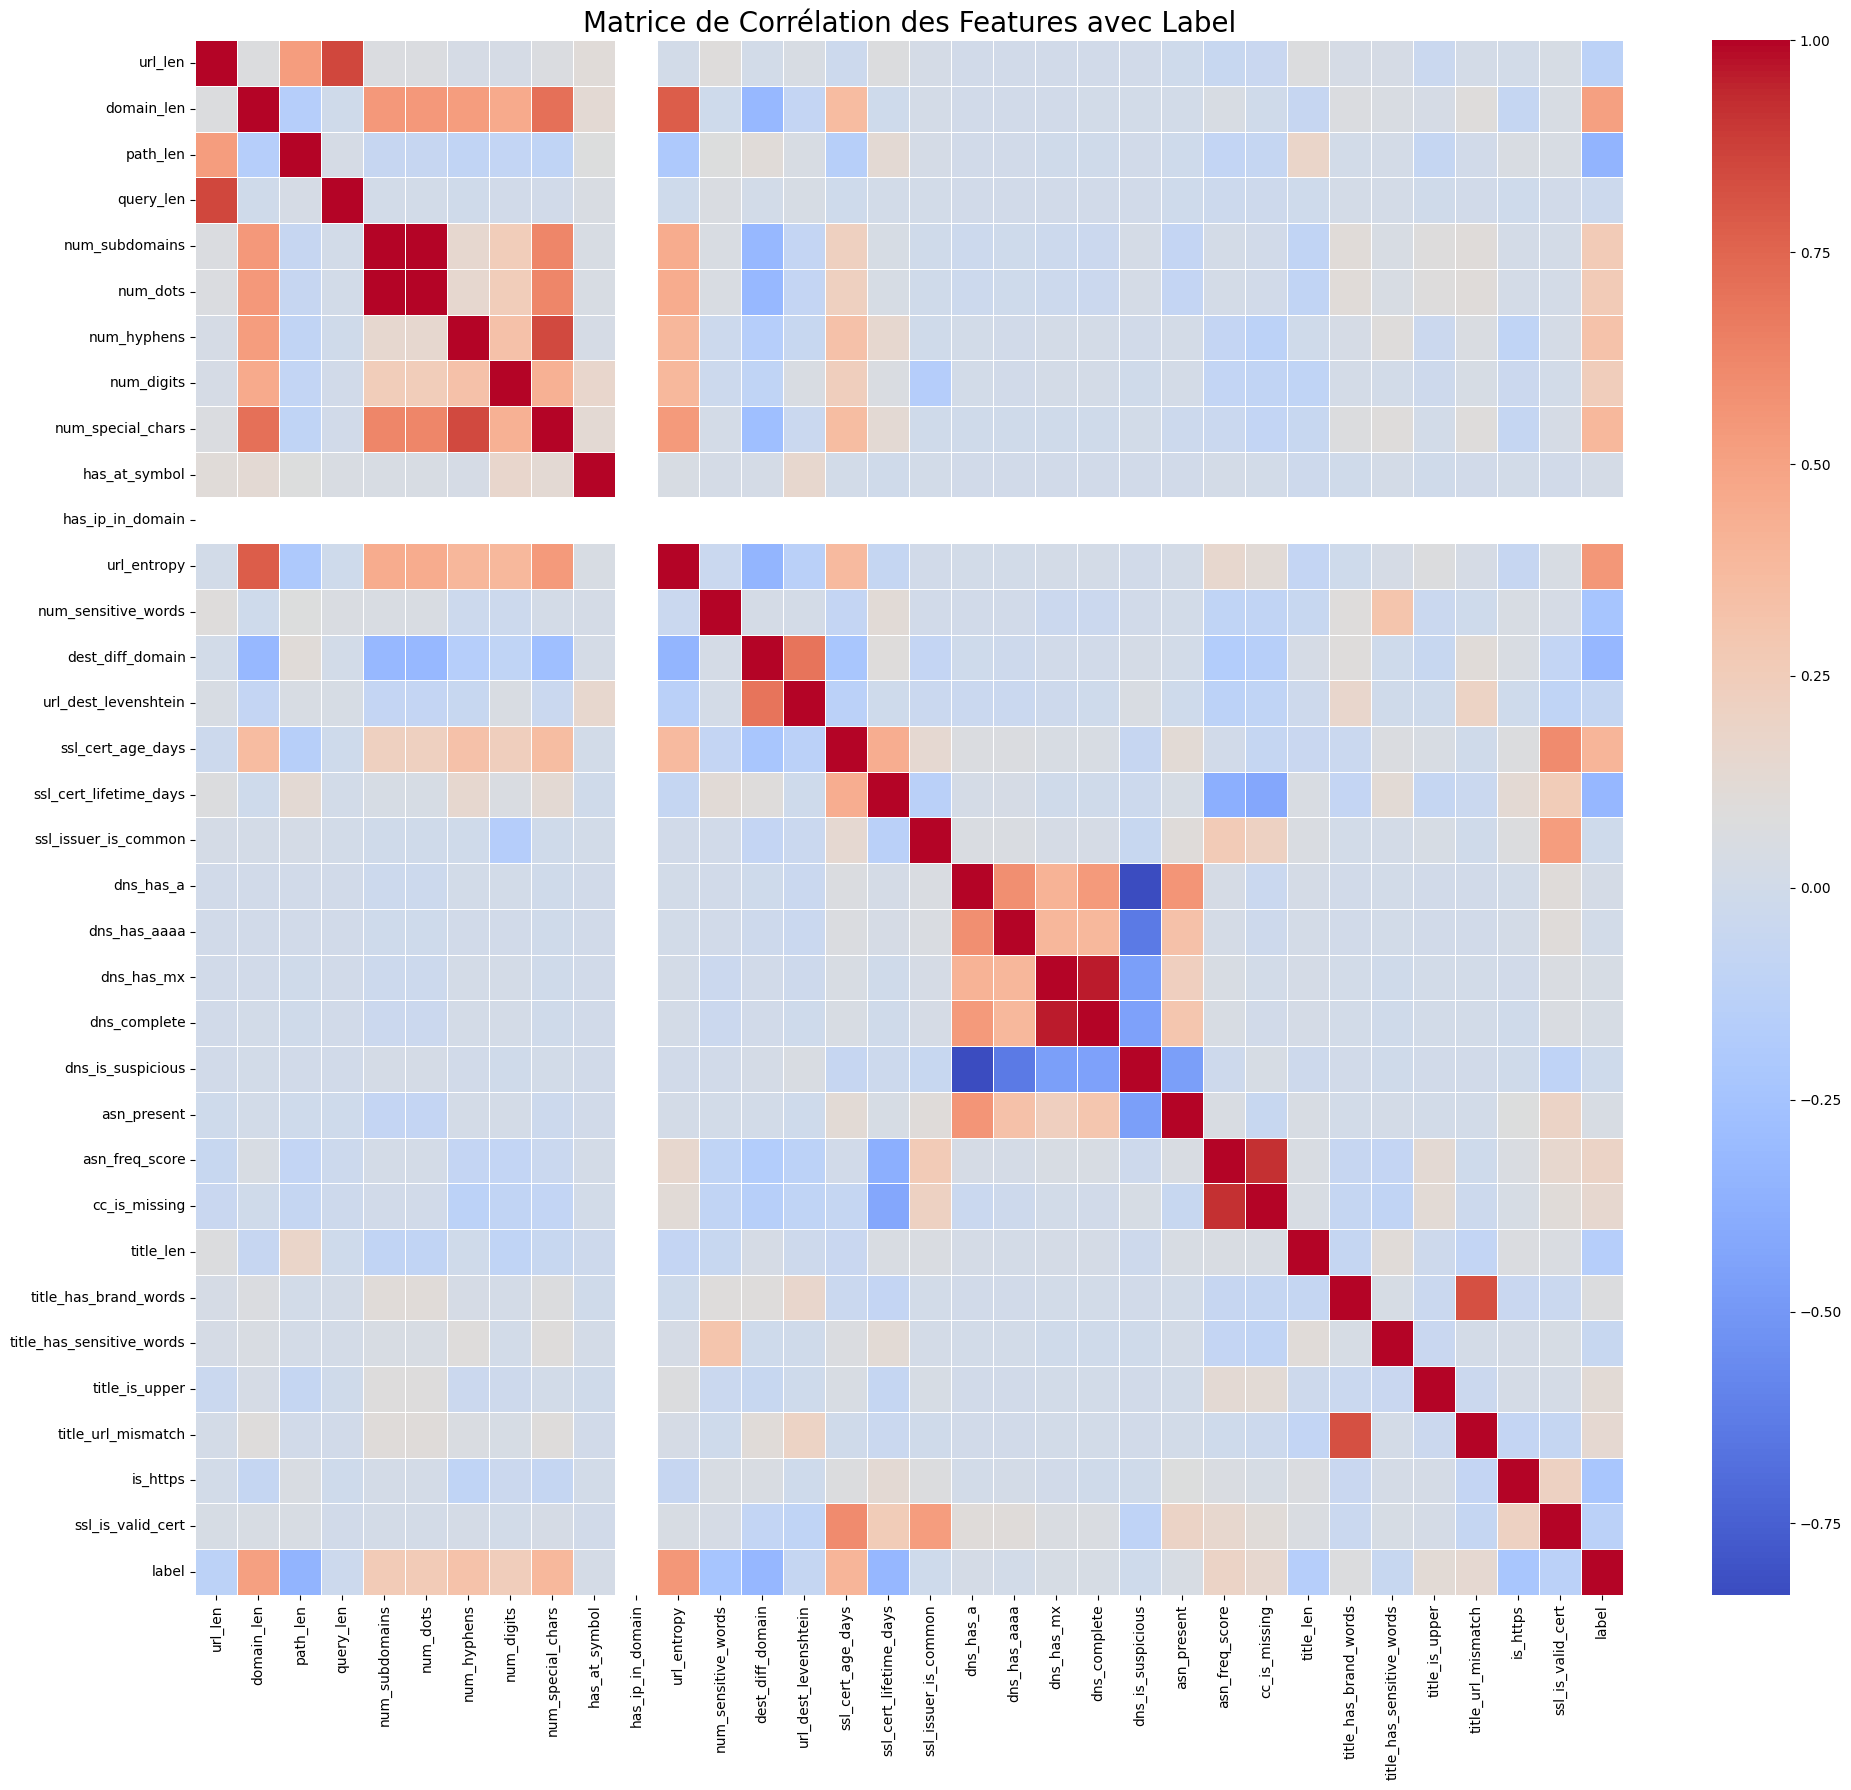

✅ Matrice de corrélation avec label affichée.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n" + "="*70)
print("📊 MATRICE DE CORRÉLATION DES FEATURES AVEC LABEL")
print("="*70)

# Combiner les features (X) et les labels (y) en un seul DataFrame
df_with_labels = X.copy()
df_with_labels['label'] = y

# Calcul de la matrice de corrélation avec le label
correlation_matrix_with_labels = df_with_labels.corr()

# Affichage de la heatmap
plt.figure(figsize=(20, 18)) # Ajustez la taille pour une meilleure lisibilité
sns.heatmap(correlation_matrix_with_labels, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation des Features avec Label', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Matrice de corrélation avec label affichée.")

# 🤖 Préparation du Machine Learning

Importation des bibliothèques pour :
- La préparation des données (train/test split, standardisation)
- Les modèles de classification
- Les métriques d'évaluation
- La visualisation des résultats

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

# 🔀 Division Train/Test et Standardisation

**Split stratifié 80/20** :
- 80% des données pour l'entraînement
- 20% pour le test final
- Stratification pour garder le même ratio phishing/benign dans train et test

**Standardisation** :
- Normalisation des features (moyenne = 0, écart-type = 1)
- Nécessaire pour la régression logistique
- Les modèles basés sur les arbres n'en ont pas besoin mais ça ne nuit pas

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*70)
print("🔀 SPLIT DES DONNÉES")
print("="*70)

# Split train/test avec stratification (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Train set: {X_train.shape[0]} samples")
print(f"✅ Test set:  {X_test.shape[0]} samples")
print(f"   - Phishing train: {(y_train == 1).sum()}")
print(f"   - Benign train:   {(y_train == 0).sum()}")
print(f"   - Phishing test:  {(y_test == 1).sum()}")
print(f"   - Benign test:    {(y_test == 0).sum()}")

# Standardisation des features
print("\n📊 Standardisation des features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Standardisation terminée!")

🔀 SPLIT DES DONNÉES
✅ Train set: 47345 samples
✅ Test set:  11837 samples
   - Phishing train: 23673
   - Benign train:   23672
   - Phishing test:  5918
   - Benign test:    5919

📊 Standardisation des features...
✅ Standardisation terminée!


# 🎯 Configuration des Modèles à Entraîner

Nous allons comparer **5 algorithmes** de classification :

1. **Logistic Regression** : Simple et rapide, bon baseline
2. **Random Forest** : Ensemble de décision trees, robuste
3. **Gradient Boosting** : Boosting séquentiel, très performant
4. **XGBoost** : Version optimisée du gradient boosting
5. **LightGBM** : Encore plus rapide que XGBoost

Chaque modèle est configuré avec des hyperparamètres raisonnables.

In [ ]:
print("\n" + "="*70)
print("🤖 CONFIGURATION DES MODÈLES")
print("="*70)

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=100,      # 100 arbres
        max_depth=20,          # Profondeur max = 20
        min_samples_split=5,   # Min 5 échantillons pour split
        random_state=42,
        n_jobs=-1              # Utiliser tous les CPU
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric='logloss'
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbose=-1             # Pas de logs verbeux
    )
}

print(f"✅ {len(models)} modèles configurés et prêts à l'entraînement")


🤖 CONFIGURATION DES MODÈLES
✅ 5 modèles configurés et prêts à l'entraînement


# 🏋️ Entraînement et Évaluation des Modèles

Pour chaque modèle :
1. ⏱️ Mesure du temps d'entraînement
2. 🎯 Entraînement sur le train set
3. 🔮 Prédiction sur le test set
4. 📊 Calcul de toutes les métriques (accuracy, precision, recall, F1, ROC-AUC)
5. 💾 Stockage des résultats

In [ ]:
results = {}

for name, model in models.items():
    print(f"\n🔧 Entraînement: {name}...")
    start_time = datetime.now()

    # Utiliser les données scaled pour Logistic Regression, non-scaled pour les arbres
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Stockage des résultats
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"   ✅ Terminé en {training_time:.2f}s")
    print(f"   📊 Accuracy:  {accuracy:.4f}")
    print(f"   📊 Precision: {precision:.4f}")
    print(f"   📊 Recall:    {recall:.4f}")
    print(f"   📊 F1-Score:  {f1:.4f}")
    print(f"   📊 ROC-AUC:   {roc_auc:.4f}")


🔧 Entraînement: Logistic Regression...
   ✅ Terminé en 0.62s
   📊 Accuracy:  0.9850
   📊 Precision: 0.9846
   📊 Recall:    0.9855
   📊 F1-Score:  0.9851
   📊 ROC-AUC:   0.9958

🔧 Entraînement: Random Forest...
   ✅ Terminé en 4.27s
   📊 Accuracy:  0.9973
   📊 Precision: 0.9990
   📊 Recall:    0.9956
   📊 F1-Score:  0.9973
   📊 ROC-AUC:   0.9999

🔧 Entraînement: Gradient Boosting...
   ✅ Terminé en 15.79s
   📊 Accuracy:  0.9971
   📊 Precision: 0.9978
   📊 Recall:    0.9965
   📊 F1-Score:  0.9971
   📊 ROC-AUC:   0.9999

🔧 Entraînement: XGBoost...
   ✅ Terminé en 0.75s
   📊 Accuracy:  0.9973
   📊 Precision: 0.9980
   📊 Recall:    0.9966
   📊 F1-Score:  0.9973
   📊 ROC-AUC:   0.9999

🔧 Entraînement: LightGBM...
   ✅ Terminé en 0.92s
   📊 Accuracy:  0.9973
   📊 Precision: 0.9981
   📊 Recall:    0.9965
   📊 F1-Score:  0.9973
   📊 ROC-AUC:   0.9999


# 🏆 Comparaison des performances des modèles

Cette section présente une **comparaison détaillée des performances** des différents modèles de classification entraînés pour la détection de sites de phishing.

Un **tableau récapitulatif** est généré afin de comparer objectivement chaque modèle selon plusieurs métriques standards en classification binaire.

## 📊 Métriques utilisées

Les modèles sont évalués à l’aide des métriques suivantes :

- **Accuracy** : proportion globale de prédictions correctes sur l’ensemble de test.
- **Precision** : capacité du modèle à réduire les faux positifs (sites légitimes classés à tort comme phishing).
- **Recall** : capacité du modèle à détecter efficacement les sites de phishing (métrique critique en cybersécurité).
- **F1-Score** : moyenne harmonique entre la précision et le rappel, utilisée comme critère principal de comparaison.
- **ROC-AUC** : capacité globale du modèle à distinguer les classes phishing et légitime.
- **Temps d’entraînement** : durée nécessaire à l’apprentissage du modèle.

## 🏆 Sélection du meilleur modèle

Les modèles sont **classés par ordre décroissant de F1-Score**, afin d’identifier le meilleur compromis entre détection des attaques et limitation des faux positifs.

Le **meilleur modèle est sélectionné automatiquement** à partir de ce classement et utilisé pour :
- l’analyse détaillée des performances,
- la génération des visualisations,
- l’étude de l’importance des caractéristiques,
- la sauvegarde finale du modèle entraîné.

Cette approche garantit une **comparaison équitable et reproductible** entre les différentes méthodes testées.



📊 COMPARAISON DES MODÈLES
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
            XGBoost  0.997297   0.997970 0.996620  0.997295 0.999930           0.748595
           LightGBM  0.997297   0.998138 0.996452  0.997294 0.999936           0.920078
      Random Forest  0.997297   0.998983 0.995607  0.997292 0.999941           4.266480
  Gradient Boosting  0.997128   0.997800 0.996452  0.997125 0.999916          15.789708
Logistic Regression  0.985047   0.984636 0.985468  0.985052 0.995786           0.616797

🏆 MEILLEUR MODÈLE: XGBoost

📈 VISUALISATIONS
✅ Graphiques sauvegardés: model_comparison.png


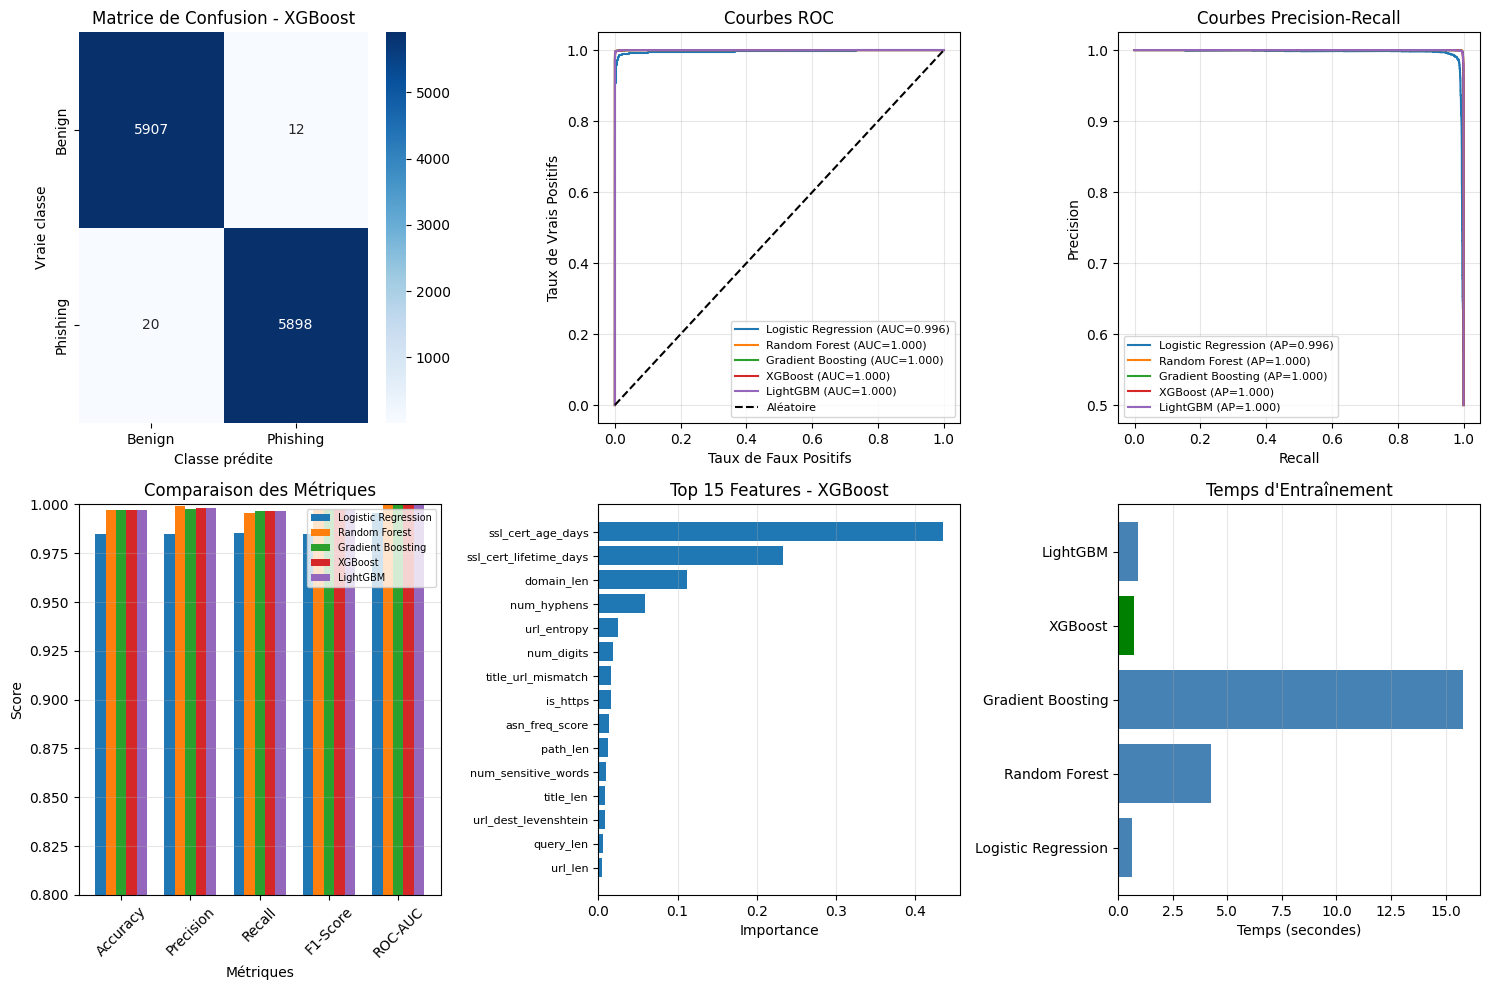


💾 SAUVEGARDE DU MEILLEUR MODÈLE
✅ Modèle sauvegardé: /content/drive/MyDrive/Dataset/best_phishing_model.pkl
✅ Scaler sauvegardé: /content/drive/MyDrive/Dataset/feature_scaler.pkl
✅ Noms des features sauvegardés: /content/drive/MyDrive/Dataset/feature_names.pkl

📋 RAPPORT DÉTAILLÉ - XGBoost
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5919
    Phishing       1.00      1.00      1.00      5918

    accuracy                           1.00     11837
   macro avg       1.00      1.00      1.00     11837
weighted avg       1.00      1.00      1.00     11837


✅ ENTRAÎNEMENT TERMINÉ !


In [ ]:
print("\n" + "="*70)
print("📊 COMPARAISON DES MODÈLES")
print("="*70)

# Créer un DataFrame de comparaison
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1-Score': [r['f1'] for r in results.values()],
    'ROC-AUC': [r['roc_auc'] for r in results.values()],
    'Training Time (s)': [r['training_time'] for r in results.values()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print(comparison_df.to_string(index=False))

# Meilleur modèle
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")

# ============================================================================
print("\n" + "="*70)
print("📈 VISUALISATIONS")
print("="*70)

# 1. Matrice de confusion pour le meilleur modèle
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'])
plt.title(f'Matrice de Confusion - {best_model_name}')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')

# 2. Courbe ROC
plt.subplot(2, 3, 2)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
plt.subplot(2, 3, 3)
for name, result in results.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    avg_precision = average_precision_score(y_test, result['y_pred_proba'])
    plt.plot(recall_curve, precision_curve, label=f"{name} (AP={avg_precision:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbes Precision-Recall')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 4. Comparaison des métriques
plt.subplot(2, 3, 4)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.15

for i, (name, result) in enumerate(results.items()):
    values = [result['accuracy'], result['precision'], result['recall'],
              result['f1'], result['roc_auc']]
    plt.bar(x + i*width, values, width, label=name)

plt.xlabel('Métriques')
plt.ylabel('Score')
plt.title('Comparaison des Métriques')
plt.xticks(x + width*2, metrics, rotation=45)
plt.legend(fontsize=7)
plt.ylim(0.8, 1.0)
plt.grid(True, alpha=0.3, axis='y')

# 5. Feature Importance (pour le meilleur modèle si tree-based)
plt.subplot(2, 3, 5)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-15:]  # Top 15

    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices], fontsize=8)
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model_name}')
    plt.grid(True, alpha=0.3, axis='x')
else:
    plt.text(0.5, 0.5, 'Feature importance\nnon disponible\npour ce modèle',
             ha='center', va='center', fontsize=12)
    plt.axis('off')

# 6. Temps d'entraînement
plt.subplot(2, 3, 6)
training_times = [r['training_time'] for r in results.values()]
model_names = list(results.keys())
colors = ['green' if name == best_model_name else 'steelblue' for name in model_names]
plt.barh(model_names, training_times, color=colors)
plt.xlabel('Temps (secondes)')
plt.title('Temps d\'Entraînement')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dataset/model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Graphiques sauvegardés: model_comparison.png")
plt.show()

# ============================================================================
print("\n" + "="*70)
print("💾 SAUVEGARDE DU MEILLEUR MODÈLE")
print("="*70)

# Sauvegarder le modèle
model_path = '/content/drive/MyDrive/Dataset/best_phishing_model.pkl'
scaler_path = '/content/drive/MyDrive/Dataset/feature_scaler.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✅ Modèle sauvegardé: {model_path}")

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler sauvegardé: {scaler_path}")

# Sauvegarder les noms des features
feature_names_path = '/content/drive/MyDrive/Dataset/feature_names.pkl'
with open(feature_names_path, 'wb') as f:
    pickle.dump(list(X.columns), f)
print(f"✅ Noms des features sauvegardés: {feature_names_path}")

# Rapport détaillé pour le meilleur modèle
print("\n" + "="*70)
print(f"📋 RAPPORT DÉTAILLÉ - {best_model_name}")
print("="*70)
print(classification_report(y_test, results[best_model_name]['y_pred'],
                          target_names=['Benign', 'Phishing']))

print("\n" + "="*70)
print("✅ ENTRAÎNEMENT TERMINÉ !")
print("="*70)